In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy

import npeet.entropy_estimators as ee
from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad

In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import mixed

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import tree

In [4]:
# Taken from Richard's "Reprod Figure 2"
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), int((1 - max_samples)*len(X)))
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

/home/ronak/miniconda3/envs/uf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
# def split_train_eval(X, y, frac_eval):
    
#     if frac_eval == 0:
#         return X, y, [], []
    
#     n = len(y)
#     n_eval = int(np.floor(frac_eval*n))
#     eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
#     X_eval = X[eval_indices, :]
#     y_eval = y[eval_indices]
#     X = np.delete(X, eval_indices, axis = 0)
#     y = np.delete(y, eval_indices, axis = 0)
    
#     return X, y, X_eval, y_eval

def generate_data(n, d, mu = 1, var1 = 1, pi = 0.5, truncate = False, three_class = False):
    
    means, Sigma, probs = _make_params(d, mu = mu, var1 = var1, pi = pi, three_class = three_class)
    counts = np.random.multinomial(n, probs, size = 1)[0]
    
    X_data = []
    y_data = []
    for k in range(len(probs)):
        X_data.append(np.random.multivariate_normal(means[k], Sigma, counts[k]))
        y_data.append(np.repeat(k, counts[k]))
    X = np.concatenate(tuple(X_data))
    y = np.concatenate(tuple(y_data))
    
    if truncate:
        for i in range(n):
            if X[i, 0] > 0:
                y[i] = 0
            elif X[i, 0] < 0:
                y[i] = 1
    
    return X, y

def _make_params(d, mu = 1, var1 = 1, pi = 0.5, three_class = False):
    
    if three_class:
        return _make_three_class_params(d, mu)
    
    mean = np.zeros(d)
    mean[0] = mu
    means = [mean, -mean]
    Sigma = np.eye(d)
    Sigma[0, 0] = var1
    probs = [pi, 1 - pi]
    
    return means, Sigma, probs

def _make_three_class_params(d, mu):
    
    means = []
    mean = np.zeros(d)
    
    mean[0] = mu
    means.append(copy.deepcopy(mean))
    
    mean[0] = -mu
    means.append(copy.deepcopy(mean))
    
    mean[0] = 0
    mean[d-1] = mu
    means.append(copy.deepcopy(mean))
    
    Sigma = np.eye(d)
    probs = [1/3.]*3
    
    return means, Sigma, probs

# def split_by_class(X, y):
    
#     classes, class_indices = np.unique(y, return_inverse = True)
#     K = len(classes)
#     X_by_class = []
#     y_by_class = []
    
#     for k in range(K):
#         class_ = classes[k]
#         X_k = X[y == class_,:]
#         y_k = np.repeat(class_, X_k.shape[0])
#         X_by_class.append(X_k)
#         y_by_class.append(y_k)
        
#     return X_by_class, y_by_class

In [6]:
def plot_setting(n, setting, ax):
    
    mean = 3 if setting['name'] == 'Three Class Gaussians' else 1
    X, y = generate_data(n, 2, **setting['kwargs'], mu = mean)
        
    # X_by_class, y_by_class = split_by_class(X, y)
    colors = ["#c51b7d", "#2166ac", "#d95f02"]
    ax.scatter(X[:, 0], X[:, 1], color = np.array(colors)[y], marker = ".")
    
    # ax.set_ylim(bottom = -5.05)
    # ax.set_ylim(top = 5.05)
    ax.set_xlim(left = -5.05)
    ax.set_xlim(right = 5.05)
    
    ax.set_ylabel(setting['name'])

In [7]:
def compute_mutual_info(d, base = np.exp(1), mu = 1, var1 = 1, pi = 0.5, three_class = False, truncate = False):
    
    if d > 1:
        dim = 2
    else:
        dim = d
 
    means, Sigma, probs = _make_params(dim, mu = mu, var1 = var1, pi = pi, three_class = three_class)
    
    # Compute entropy and X and Y.
    def func(*args):
        x = np.array(args)
        p = 0
        for k in range(len(means)):
            p += probs[k] * multivariate_normal.pdf(x, means[k], Sigma)
        return -p * np.log(p) / np.log(base)

    scale = 10
    lims = [[-scale, scale]]*dim
    H_X, int_err = nquad(func, lims)
    H_Y = entropy(probs, base = base)
    
    if truncate:
        return H_Y, H_X, H_Y
    
    # Compute MI.
    H_XY = (dim * np.log(2*np.pi) + np.log(np.linalg.det(Sigma)) + dim) / (2 * np.log(base))
    I_XY = H_X - H_XY
    
    return I_XY, H_X, H_Y

In [8]:
def estimate_mi(X, y, label, base = np.exp(1)):
    _, counts = np.unique(y, return_counts=True)
    est_H_Y = entropy(counts, base=np.exp(1))
        
    if label == "UF":
        # UF
        return (est_H_Y - cef_estimate(np.array(X), y, 300, .32, depth = 30))
        
        # CART
        # cart_out = CART_estimate(X, y)
    elif label == "IRF":    
        # IRF
        frac_eval = 0.3
        irf_obj = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = frac_eval)
        irf_obj.fit(X_train, y_train)
        p = irf_obj.predict_proba(X_eval)
        return (est_H_Y - np.mean(entropy(p.T, base = base))) 
    elif label == "KSG": 
        # KSG
        return ee.mi(X, np.array(y).reshape(-1, 1))
    elif label == "Mixed KSG":     
        # MKSG
        return mixed.Mixed_KSG(X, y.reshape(-1, 1))
    else:
        raise ValueError("Uncrecognized label!")

In [9]:
# def mutual_info_distribution(n, d, frac_eval, algo, num_trials, setting, base = 2, parallel = False):
#     # For each trial, generate data and compute conditional entropy for each algorithm.
#     def worker(t):
#         X, y = generate_data(n, d, **setting['kwargs'])

#         # Estimate conditional probability of Y | X.
#         obj = algo['instance']
#         return estimate_mi(X, y, algo['label'], obj, frac_eval)
    
#     if parallel:
#         predicted_mutual_info = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
#     else:
#         predicted_mutual_info = np.zeros(num_trials)
#         for t in tqdm(range(num_trials)):
#             predicted_mutual_info[t] = worker(t)
            
#     return predicted_mutual_info

In [10]:
# def sample_size_range(alpha, X_full, y_full, n, scale, frac_eval, algo, num_trials, setting, parallel, I_XY, n_max):
#     indices = np.random.choice(np.arange(n_max), size=n, replace=False)
#     X = X_full[indices,:]
#     y = y_full[indices]
#     if n >= n_max:
#         return n
#     mi_dist = mutual_info_distribution(n, d, frac_eval, algo, num_trials, setting, parallel = parallel)
#     rel_err = np.mean(np.abs(mi_dist - I_XY)) / I_XY
#     if rel_err > alpha:
#         print("Checking if %s converges in %d samples for %s." % (algo['title'], scale*n, setting['name']))
#         return MI_by_algo_d(alpha, d, n*scale, scale, frac_eval, algo, num_trials, setting, parallel, I_XY, n_max)
#     print("Running binary search.")
#     return binary_search(alpha, d, n, scale, frac_eval, algo, num_trials, setting, parallel, I_XY)

# def binary_search(alpha, d, n, scale, frac_eval, algo, num_trials, setting, parallel, I_XY):
#     start = n // 2
#     end = n
#     mid = (start + end) // 2
#     prev_mid = -10000
    
#     mi_dist = mutual_info_distribution(mid, d, frac_eval, algo, num_trials, setting, parallel = parallel)
#     rel_err = np.mean(np.abs(mi_dist - I_XY)) / I_XY
#     while np.abs(prev_mid - mid) > 5:
#         prev_mid = mid
#         if rel_err > alpha:
#             start = mid
#         else:
#             end = mid
#         mid = (start + end) // 2
#         mi_dist = mutual_info_distribution(mid, d, frac_eval, algo, num_trials, setting, parallel = parallel)
#         rel_err = np.mean(np.abs(mi_dist - I_XY)) / I_XY
#     return mid

In [11]:
# Compute the number of trials until with 5% of the true MI.
# def mutual_info_by_d(alpha, scale, ds, frac_eval, algos, num_trials, setting, starting_n, n_max, base = 2, parallel = False):
    
#     # Repeat for all 'd', and save output in the 'algos' array.
#     num_sample_range = np.zeros((len(ds), len(algos)))
#     MI_by_algo = np.repeat(1000, len(algos))
    
#     # Increase n until estimate is within alpha*100% of the true I_XY.
#     for i in range(len(ds)):
#         I_XY = compute_norm_mutual_info(ds[i], **setting['kwargs'])[0]
#         for j in range(len(algos)):
#             num_sample_range[i, j] = MI_by_algo_d(alpha, 
#                                                   ds[i], 
#                                                   starting_n, 
#                                                   scale, 
#                                                   frac_eval, 
#                                                   algos[j], 
#                                                   num_trials, 
#                                                   setting,
#                                                   parallel, 
#                                                   I_XY,
#                                                   n_max)
                             
#     for j in range(len(algos)):
#         algos[j]['mi_by_d_%s' % setting['filename']] = num_sample_range[:, j]
        
#     with open('algos_fig4.pkl', 'wb') as f:
#         pickle.dump(algos, f)
#     with open('ds_fig4.pkl', 'wb') as f:
#         pickle.dump(ds, f)
        
#     return algos

In [12]:
def bounds_for_conv(label, X_full, y_full, I_XY, alpha, n):

    if n >= len(X_full):
        return n, n
    
    # By what factor to increase n when checking for the next one.
    scale = 2
    
    rel_err = compute_rel_err(X_full, y_full, label, I_XY, n)
    if rel_err > alpha:
        return bounds_for_conv(label, X_full, y_full, I_XY, alpha, n * scale)
    else:
        return n // scale, n
    
def compute_rel_err(X_full, y_full, label, I_XY, n):
    indices = np.random.choice(np.arange(len(X_full)), size=n, replace=False)
    X = X_full[indices,:]
    y = y_full[indices]
    mi_est = estimate_mi(X, y, label)
    return np.abs(mi_est - I_XY) / I_XY
    
def binary_search(label, X_full, y_full, I_XY, alpha, lower, upper):
    precision = 5
    
    start = lower
    end = upper
    mid = (start + end) // 2
    prev_mid = -10000
    
    rel_err = compute_rel_err(X_full, y_full, label, I_XY, mid)    
    while np.abs(prev_mid - mid) > precision:
        prev_mid = mid
        if rel_err > alpha:
            start = mid
        else:
            end = mid
        mid = (start + end) // 2

        rel_err = compute_rel_err(X_full, y_full, label, I_XY, mid)
    return mid

def num_samples_to_conv(label, X_full, y_full, I_XY, alpha):
    # Find numbers lower and higher than the number required for convergence.
    n_min = 200
    lower, upper = bounds_for_conv(label, X_full, y_full, I_XY, alpha, n_min)
    if upper == lower:
        return upper
    
    # Search for the number between them for which it converges.
    return binary_search(label, X_full, y_full, I_XY, alpha, lower, upper)

In [13]:
def get_mutual_info_vs_d(ds, num_trials, setting, alpha, n_max, mu = 1, base = np.exp(1)):
    
    uf = np.zeros((len(ds), num_trials))
    irf = np.zeros((len(ds), num_trials))
    ksg = np.zeros((len(ds), num_trials))
    mksg = np.zeros((len(ds), num_trials))
    
    def worker(t):
        X_full, y_full = generate_data(n_max, d = elem, **setting['kwargs'])
        I_XY, H_X, H_Y = compute_mutual_info(d = elem, **setting['kwargs'])
        
        uf_out = num_samples_to_conv("UF", X_full, y_full, I_XY, alpha)
        irf_out = num_samples_to_conv("IRF", X_full, y_full, I_XY, alpha)
        ksg_out = num_samples_to_conv("KSG", X_full, y_full, I_XY, alpha)
        mksg_out = num_samples_to_conv("Mixed KSG", X_full, y_full, I_XY, alpha)
        
        return (uf_out, irf_out, ksg_out, mksg_out)
    
    for i, elem in enumerate(ds):
        output = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        uf[i, :] = output[:, 0]
        irf[i, :] = output[:, 1]
        ksg[i, :] = output[:, 2]
        mksg[i, :] = output[:, 3]
        
    pickle.dump(ds, open('ds.pkl', 'wb'))
    pickle.dump(uf, open('uf_by_d_%s.pkl' % setting['filename'], 'wb'))
    # pickle.dump(cart, open('cart_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
    pickle.dump(irf, open('irf_by_d_%s.pkl' % setting['filename'], 'wb'))
    pickle.dump(ksg, open('ksg_by_d_%s.pkl' % setting['filename'], 'wb'))
    pickle.dump(mksg, open('mksg_by_d_%s.pkl' % setting['filename'], 'wb'))

    return uf, irf, ksg, mksg

In [14]:
# Setting figures.
# colors = ["#d95f02", "#2166ac", "#c51b7d"]
settings = [
    {
        'name' : 'Sphereical Gaussians',
        'kwargs': {},
        # 'colors' : colors[1:3],
        'filename' : 'spherical'
    },
    {
        'name' : 'Imbalanced Classes',
        'kwargs': {'pi' : 0.8},
        # 'colors' : colors[1:3],
        'filename' : 'imbalanced'
    },
    {
        'name' : 'Truncated Gaussians',
        'kwargs': {'truncate' : True},
        # 'colors' : colors[1:3],
        'filename' : 'truncated'
    },
    {
        'name' : 'Three Class Gaussians',
        'kwargs': {'three_class' : True},
        # 'colors' : colors,
        'filename' : 'three_class'
    },
]

In [15]:
# Data.
num_trials = 20
# frac_eval = 0.3
# scale = 2
alpha = 0.1
ds = range(1, 21)
# n_estimators = 5
# starting_n = 100
n_max = 10000

# Algorithms.
algos = [
    {
        # 'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
    {
        # 'instance': None,
        'label': 'KSG',
        'title': 'KSG',
        'color': "#1b9e77",
    },
    {
        # 'instance': None,
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "purple",
    },
    {
#         'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators), 
#                                            method='isotonic', 
#                                            cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
]

# Other.
num_plotted_trials = 5
parallel = False

In [16]:
for setting in settings:
    get_mutual_info_vs_d(ds, num_trials, setting, alpha, n_max)

In [17]:
def plot_mutual_info_by_d(ds, setting, algos, ax):
    
    ds = pickle.load(open('ds.pkl', 'rb'))
    uf = pickle.load(open('uf_by_d_%s.pkl' % setting['filename'], 'rb'))
    # pickle.dump(cart, open('cart_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
    irf = pickle.load(open('irf_by_d_%s.pkl' % setting['filename'], 'rb'))
    ksg = pickle.load(open('ksg_by_d_%s.pkl' % setting['filename'], 'rb'))
    mksg = pickle.load(open('mksg_by_d_%s.pkl' % setting['filename'], 'rb'))
    results = [irf, ksg, mksg, uf]
    
    for j, algo in enumerate(algos):
        # Plot the mean over trials as a solid line.
        if not algo['label'] == 'KSG':
            ax.plot(ds, 
                    np.mean(results[j], axis = 1).flatten(), 
                    label = algo['label'], 
                    linewidth = 2, 
                    color = algo['color'])

    ax.set_xlabel("Number of Dimensions")
    ax.set_ylabel("Sample Size")
    # ax.set_yscale("log")
    
#     ax.set_ylim(bottom = -0.05)
#     ax.set_ylim(top = 1.05)
    ax.set_xlim(left = .95)
    ax.set_xlim(right = np.max(ds) + 0.05)

In [18]:
def plot_fig4(ds, algos, settings, alpha):
#     with open('algos_fig4.pkl', 'rb') as f:
#         algos = pickle.load(f)
#     with open('ds_fig4.pkl', 'rb') as f:
#         ds = pickle.load(f)
        
    sns.set(font_scale = 1.4)
    sns.set_style("ticks")
    plt.figure()
    plt.rcParams["font.family"] = "sans-serif"
    fig, axes = plt.subplots(len(settings), 2, figsize = (12,18))
        
    for s, setting in enumerate(settings):
        plot_setting(2000, setting, axes[s, 0])
        plot_mutual_info_by_d(ds, setting, algos, axes[s, 1])

    axes[len(settings)-1, 1].legend(loc = 'lower right')
    axes[0, 1].set_title('Number of Samples until %d%% Error' % int(100*alpha), fontsize=16)
    axes[0, 0].set_title('Setting')
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.tight_layout()
    plt.savefig("fig4_d.pdf")
    plt.show()

<Figure size 432x288 with 0 Axes>

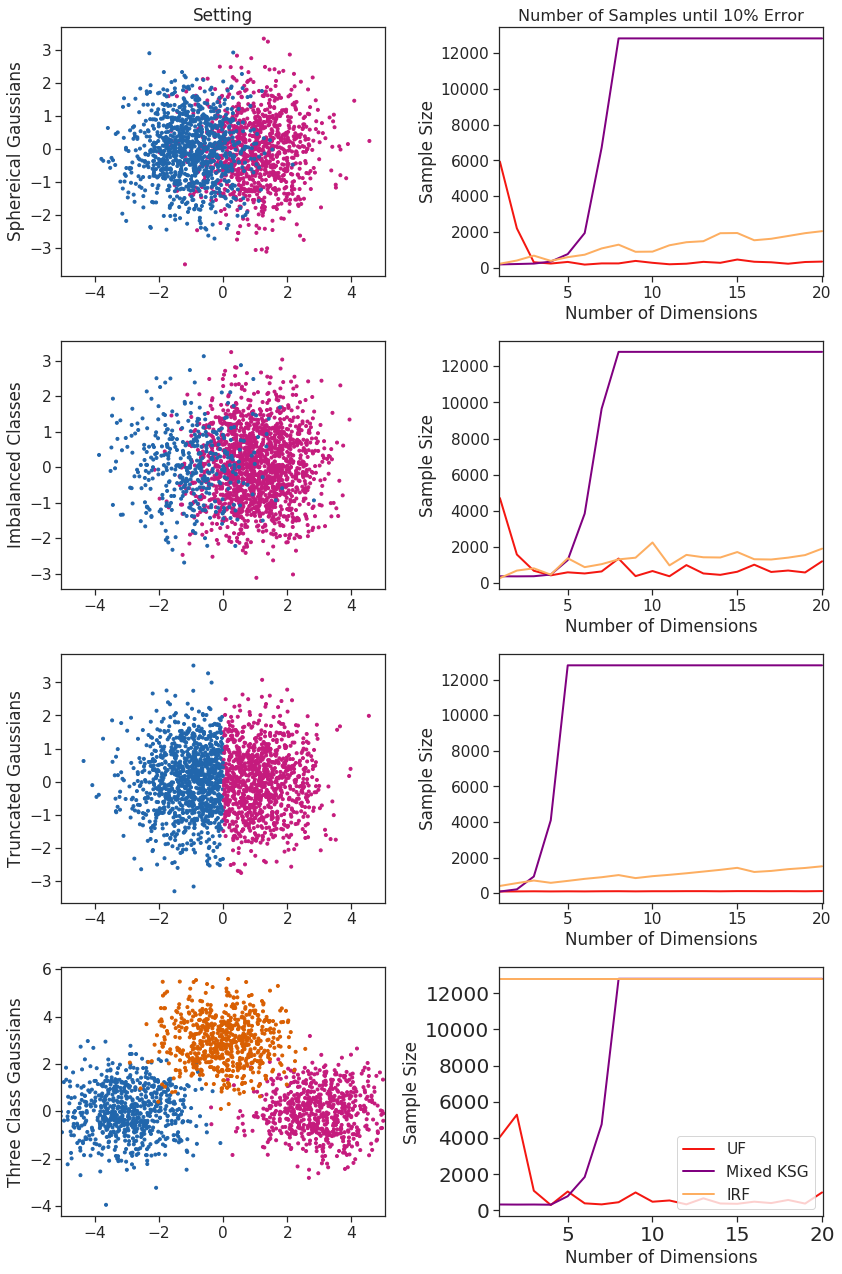

In [19]:
plot_fig4(ds, algos, settings, alpha)